## EDA

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from statsmodels.tsa.seasonal import seasonal_decompose 

from config import PROCESSED_DATA_PATH , PLOTS_DIR
from src.data_loader import save_fig


## Loading DATA

In [3]:
df = pd.read_csv('../data/processed/preprocessed_data.csv',index_col=0,parse_dates=True)
# df.index = pd.to_datetime(df.index)


def filepath(name):
    return PLOTS_DIR+f'/{name}.png'


In [4]:
df.drop(columns=['month'],axis=1,inplace=True)
df.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


##  Global_Active_Power[kw]:
### Household global minute-averaged active power (in kilowatt), It is the power that is actually consumed by an appliance averaged per minute

Below I resample over day, and show the sum and mean of Global_active_power. It is seen that mean and sum of resampled data set, have similar behaviour.

In [5]:
df["global_active_power"].head()

dt
2006-12-16 17:24:00    4.216
2006-12-16 17:25:00    5.360
2006-12-16 17:26:00    5.374
2006-12-16 17:27:00    5.388
2006-12-16 17:28:00    3.666
Name: global_active_power, dtype: float64

In [6]:
pd.DataFrame(df["global_active_power"].describe())

,global_active_power
count,2.075259e+06
mean,1.091615e+00
std,1.050655e+00
min,7.600000e-02
25%,3.100000e-01
50%,6.300000e-01
75%,1.520000e+00
max,1.112200e+01


### Histogram of Global_active_power

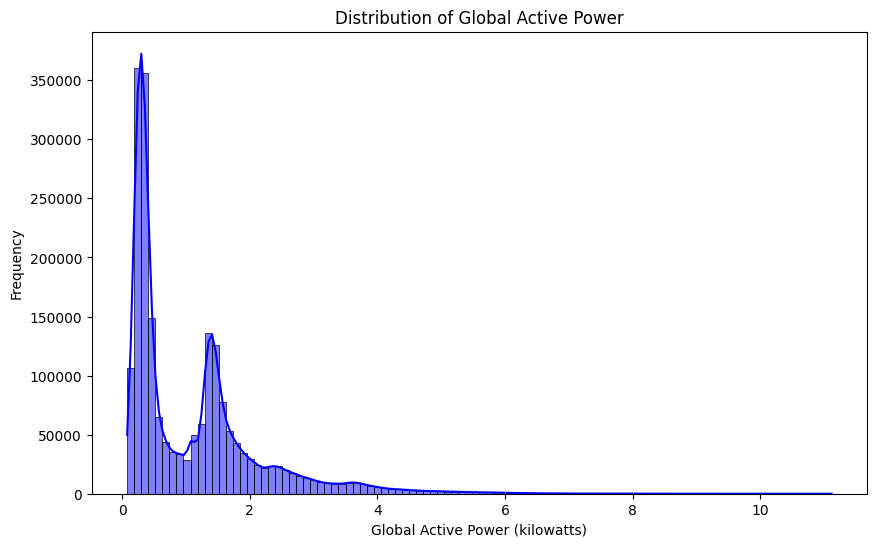

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df["global_active_power"],bins=100, kde=True, color='blue')
plt.title("Distribution of Global Active Power")
plt.xlabel("Global Active Power (kilowatts)")
plt.ylabel("Frequency")
plt.savefig(filepath('Distribution of Global Active Power'))

In [8]:
df1 = df.copy()
df1.index

DatetimeIndex(['2006-12-16 17:24:00', '2006-12-16 17:25:00',
               '2006-12-16 17:26:00', '2006-12-16 17:27:00',
               '2006-12-16 17:28:00', '2006-12-16 17:29:00',
               '2006-12-16 17:30:00', '2006-12-16 17:31:00',
               '2006-12-16 17:32:00', '2006-12-16 17:33:00',
               ...
               '2010-11-26 20:53:00', '2010-11-26 20:54:00',
               '2010-11-26 20:55:00', '2010-11-26 20:56:00',
               '2010-11-26 20:57:00', '2010-11-26 20:58:00',
               '2010-11-26 20:59:00', '2010-11-26 21:00:00',
               '2010-11-26 21:01:00', '2010-11-26 21:02:00'],
              dtype='datetime64[ns]', name='dt', length=2075259, freq=None)

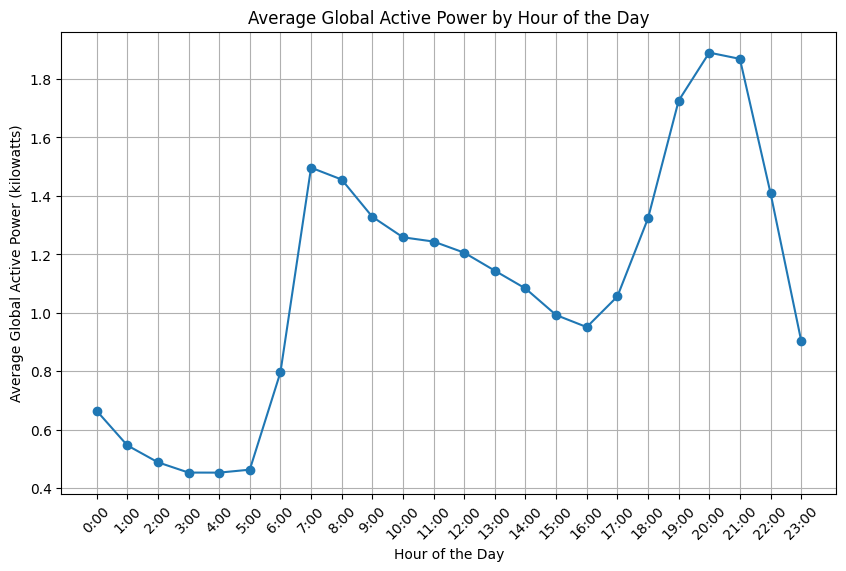

In [9]:
# to extract time information from datetime index
df1.loc[:, "Hour"] = df1.index.hour

moyenne_par_heure = df1.groupby("Hour")["global_active_power"].mean()
hours = np.arange(0, 24)
plt.figure(figsize=(10, 6))
plt.plot(hours, moyenne_par_heure, marker='o')
plt.title("Average Global Active Power by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Global Active Power (kilowatts)")
plt.xticks(hours, labels=[f"{h}:00" for h in hours], rotation=45)
plt.grid()
plt.savefig(filepath('Average Global Active Power by Hour of the Day'))

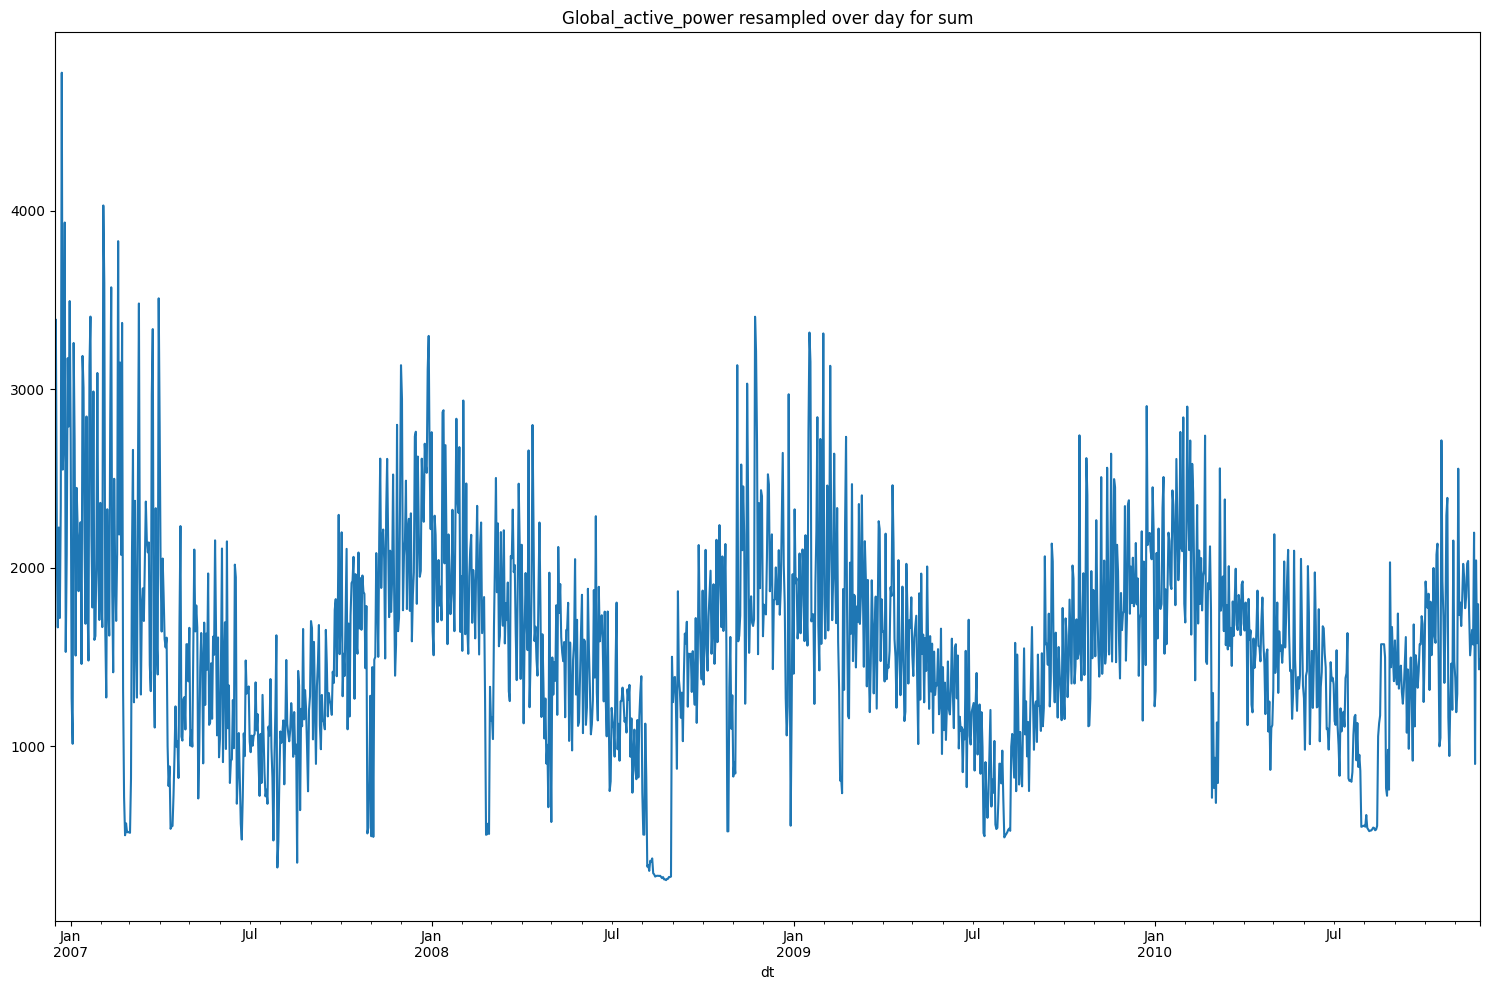

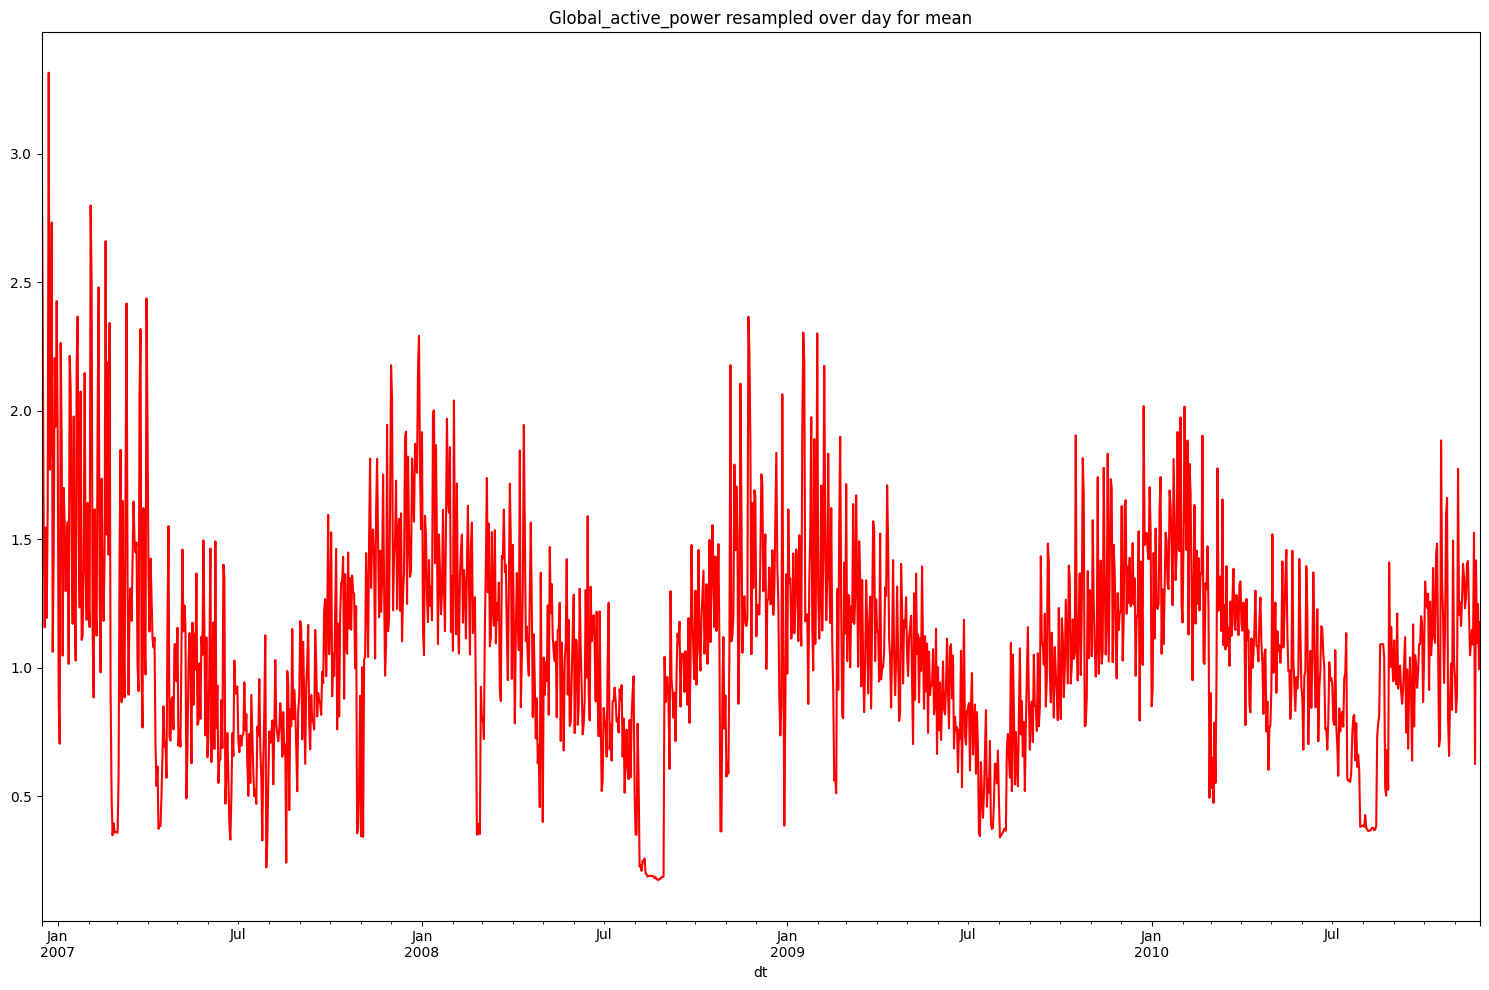

In [10]:
plt.figure(figsize=(15,10))
df.global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum') # Downsampling; converting from minutely to daily data points and summing the corresponding values
plt.tight_layout()
plt.savefig(filepath('Global_active_power resampled over day for sum'))
plt.figure(figsize=(15,10))
df.global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean' , c='red') # Downsampling; converting from minutely to daily data points and averaging the corresponding values
plt.tight_layout()
plt.savefig(filepath('Global_active_power resampled over day for mean'))


### Insights from Resampled Data (Daily)

- **Overall Trend**: No clear upward or downward long-term trend, but strong fluctuations over the years.  
- **Volatility**: The series shows high variability, with noticeable peaks and drops.  
- **Seasonality**: Recurring annual patterns are evident, with repeated peaks and troughs each year.  
- **Detailed Analysis**: Further exploration with **moving averages**, **detrending**, and **seasonal decomposition** can provide deeper insights into underlying patterns.  


In [11]:
df_resampled = df1.global_active_power.resample('D').sum().to_frame()

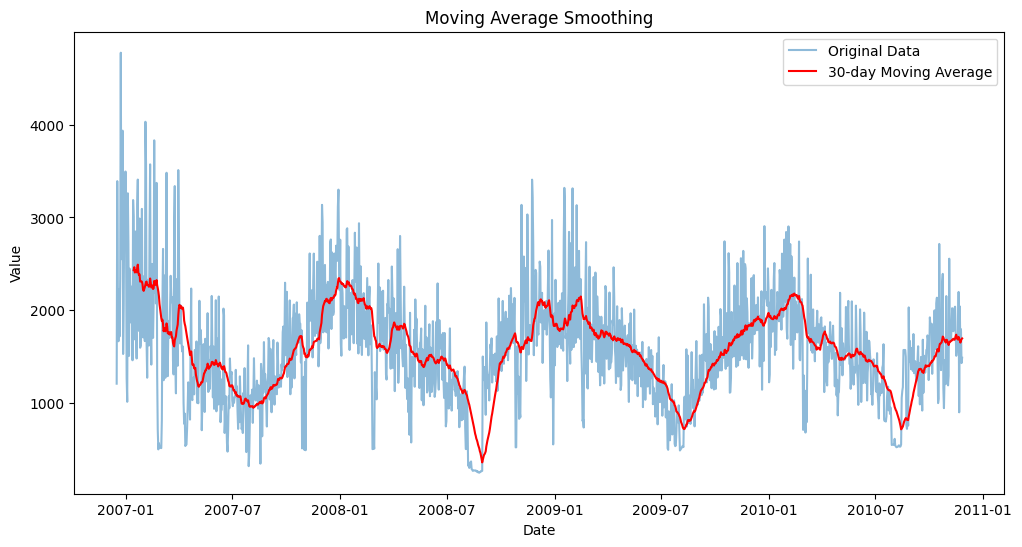

In [12]:
# 30-day moving average calculation
df_resampled['Moving_Avg'] = df_resampled['global_active_power'].rolling(window=30).mean()

# Graph
plt.figure(figsize=(12,6))
plt.plot(df_resampled['global_active_power'], label='Original Data', alpha=0.5)
plt.plot(df_resampled['Moving_Avg'], label='30-day Moving Average', color='red')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Moving Average Smoothing")
plt.savefig(filepath('Moving Average Smoothing'))

### Analysis of Daily Energy Consumption

#### 1. Trend (Long-Term Patterns)
- Clear seasonal fluctuations observed from 2007 to 2010.  
- Noticeable peaks and troughs, with significant drops around mid-2008 and early 2009.  

#### 2. Seasonality (Periodic Fluctuations)
- Regular annual cycles visible in the 30-day moving average.  
- Higher consumption in **summer and winter**, lower in **spring and fall**.  

#### 3. Volatility (Short-Term Variations)
- Daily consumption (blue line) shows strong fluctuations.  
- The 30-day moving average (red line) smooths short-term noise, revealing the overall trend more clearly.  

---

### Seasonal Decomposition
Seasonal decomposition separates a time series into three key components:  
- **Trend**: The long-term direction (increase/decrease over years).  
- **Seasonal**: Repeating patterns such as yearly or monthly cycles.  
- **Residual**: Random noise not explained by trend or seasonality.  

This decomposition is valuable for:  
- Improving forecasting models.  
- Detecting anomalies.  
- Understanding seasonal effects for energy management and demand optimization.  


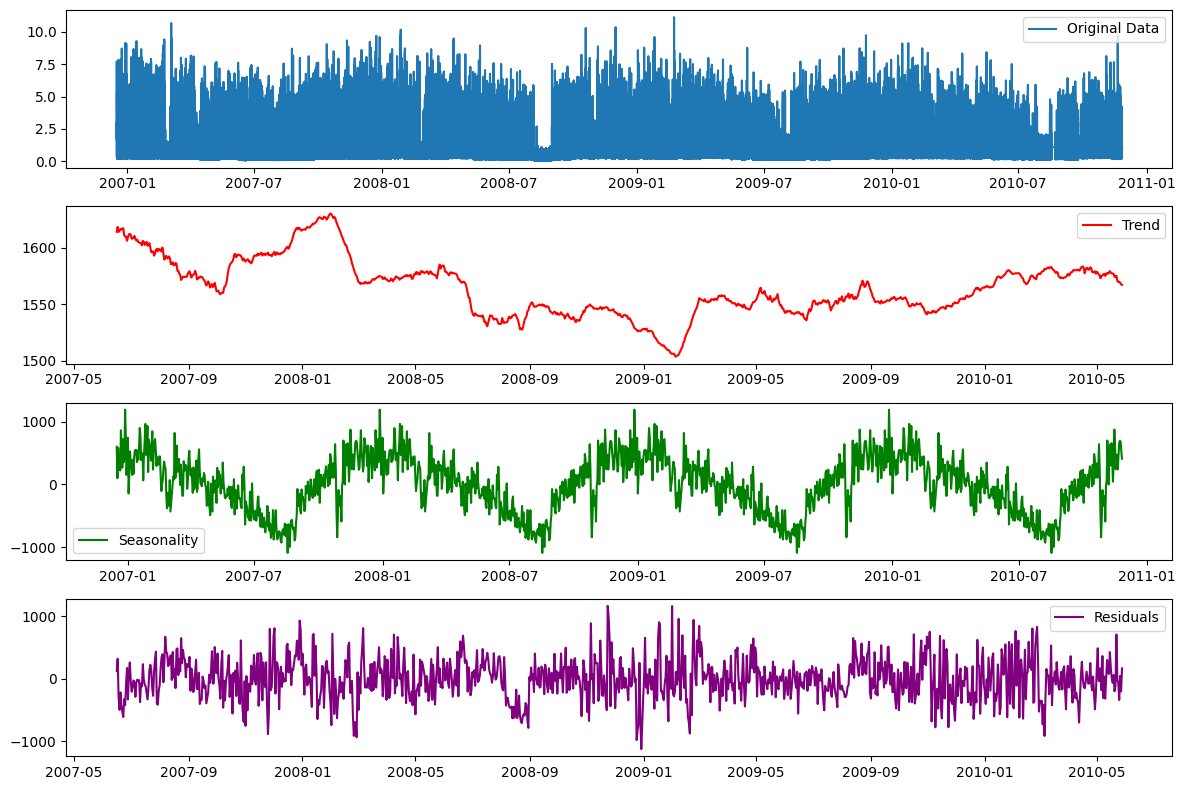

In [13]:
result = seasonal_decompose(df_resampled['global_active_power'], model='additive', period=365)  # Annual seasonal period (365 days)

# Plotting the results
plt.figure(figsize=(12,8))

plt.subplot(4,1,1)
plt.plot(df['global_active_power'], label='Original Data')
plt.legend()

plt.subplot(4,1,2)
plt.plot(result.trend, label='Trend', color='red')
plt.legend()

plt.subplot(4,1,3)
plt.plot(result.seasonal, label='Seasonality', color='green')
plt.legend()

plt.subplot(4,1,4)
plt.plot(result.resid, label='Residuals', color='purple')
plt.legend()

plt.tight_layout()
plt.savefig(filepath('Decomposition Yearly' ))

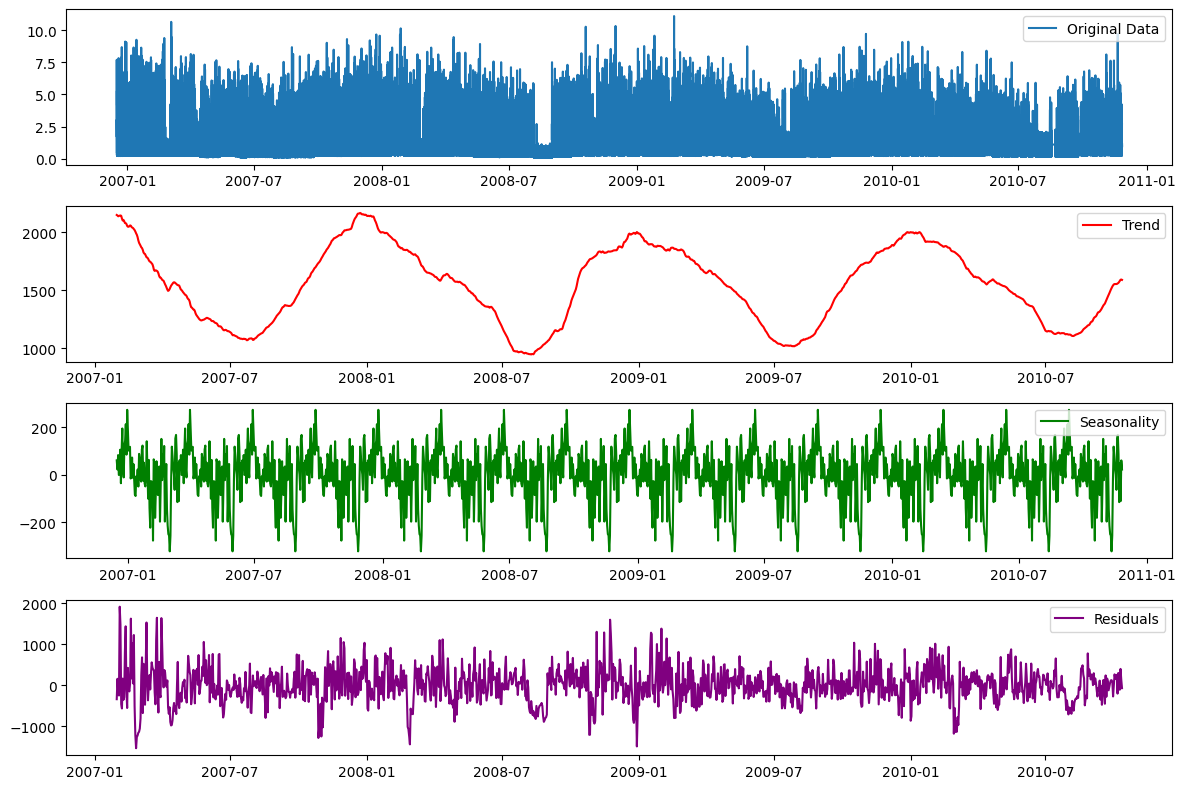

In [14]:
result = seasonal_decompose(df_resampled['global_active_power'], model='additive', period=90)  #  seasonal period (90 days)

# Plotting the results
plt.figure(figsize=(12,8))

plt.subplot(4,1,1)
plt.plot(df['global_active_power'], label='Original Data')
plt.legend()

plt.subplot(4,1,2)
plt.plot(result.trend, label='Trend', color='red')
plt.legend()

plt.subplot(4,1,3)
plt.plot(result.seasonal, label='Seasonality', color='green')
plt.legend()

plt.subplot(4,1,4)
plt.plot(result.resid, label='Residuals', color='purple')
plt.legend()

plt.tight_layout()
plt.savefig(filepath('Decomposition Quarter'))

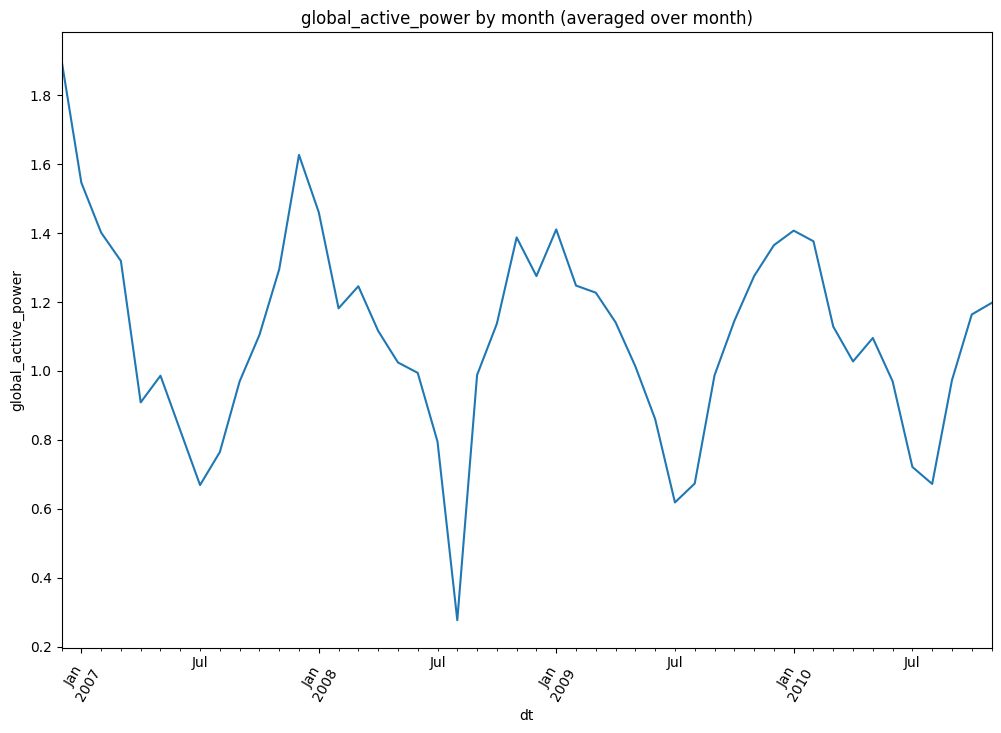

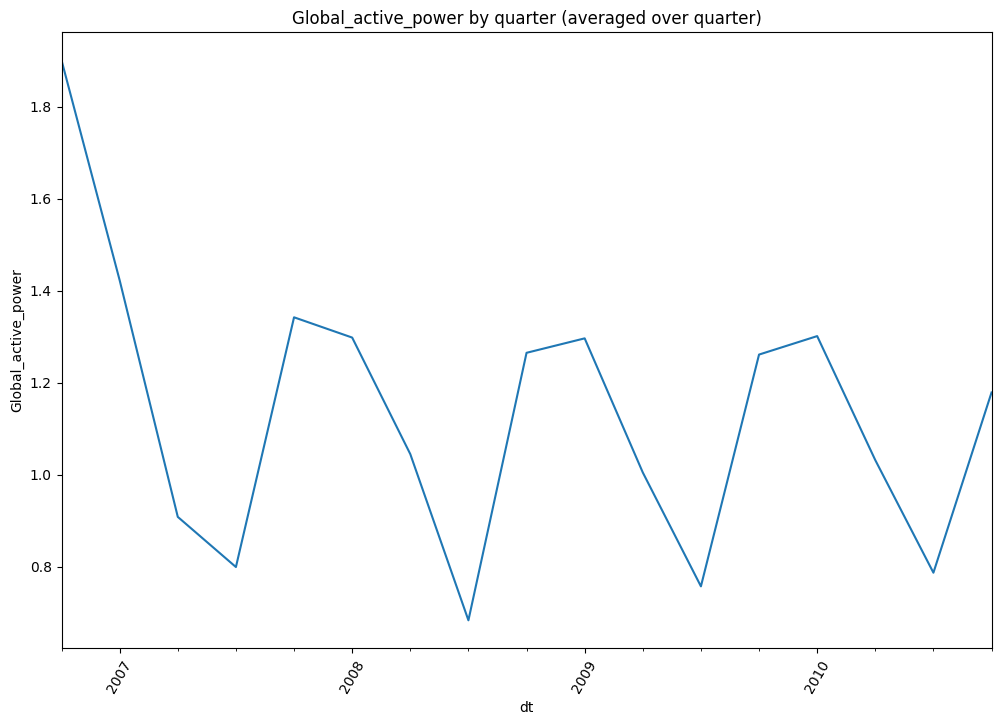

In [15]:

plt.figure(figsize=(12,8))
ax = df['global_active_power'].resample('ME').mean().plot()

xticks_dates = df.resample('ME').mean().index
plt.xticks(rotation=60)
plt.ylabel('global_active_power')
plt.title('global_active_power by month (averaged over month)')
plt.savefig(filepath('global_active_power by month (averaged over month)'))

plt.figure(figsize=(12,8))
df['global_active_power'].resample('QE').mean().plot()
df.resample('QE').mean().index
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power by quarter (averaged over quarter)')
plt.savefig(filepath('Global_active_power  by quarter (averaged over quarter)'))

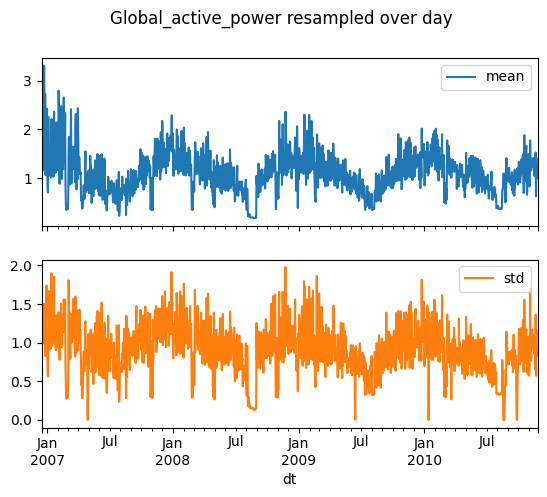

In [16]:
glob_pow = df['global_active_power'].resample('D').agg(['mean','std'])
plt.Figure(figsize=(20,8))

glob_pow.plot(subplots=True,title='Global_active_power resampled over day')
plt.savefig(filepath('Global_active_power resampled over day'))

<Figure size 1400x800 with 0 Axes>

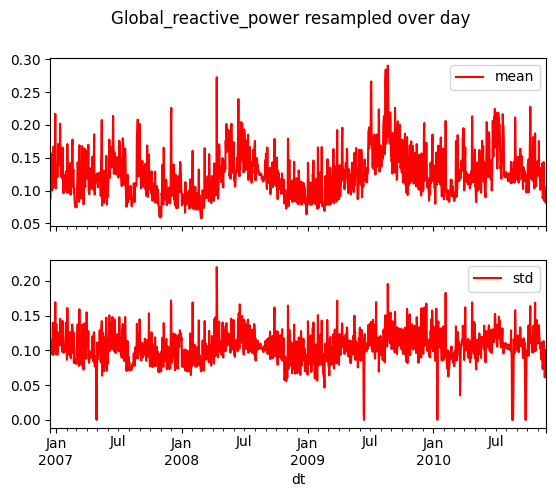

In [17]:
### Below I show mean and std of 'Global_reactive_power' resampled over day
plt.figure(figsize=(14,8))
r2 = df.global_reactive_power.resample('D').agg(['mean', 'std'])
r2.plot(subplots = True, title='Global_reactive_power resampled over day', color='red')
plt.savefig(filepath('Global_reactive_power resampled over day'))

<Figure size 2000x800 with 0 Axes>

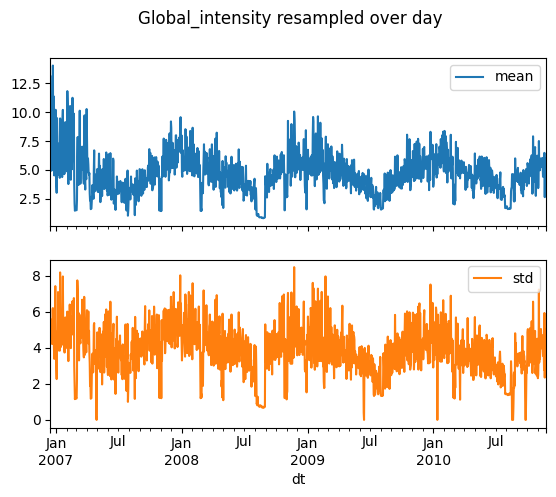

In [18]:
plt.figure(figsize=(20,8))
x = df.global_intensity.resample('D').agg(['mean', 'std'])
x.plot(subplots = True, title='Global_intensity resampled over day')
plt.savefig(filepath(name='Global_intensity resampled over day'))

<Figure size 1200x600 with 0 Axes>

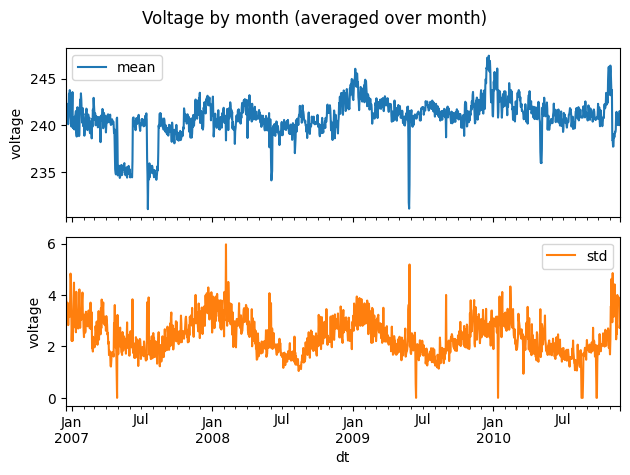

In [19]:
## mean of 'Voltage' resampled over month
plt.figure(figsize=(12,6))
ax = df['voltage'].resample('D').agg(['mean','std'])
ax.plot(subplots=True,title='Voltage by month (averaged over month)',ylabel='voltage')
plt.tight_layout()
plt.savefig(filepath('Voltage by day (averaged over month'))

<Figure size 1200x600 with 0 Axes>

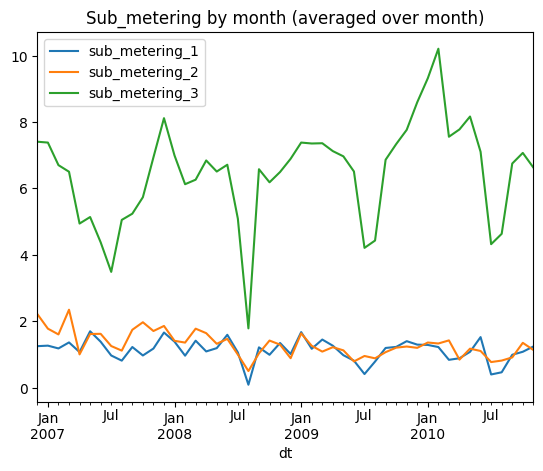

In [20]:
plt.figure(figsize=(12,6))
ax = df[['sub_metering_1','sub_metering_2','sub_metering_3']].resample('ME').mean()
ax.plot(title='Sub_metering by month (averaged over month)')
plt.savefig(filepath('Sub_metering by month (averaged over month'))

In [21]:
df[['sub_metering_1','sub_metering_2','sub_metering_3']].describe()

,sub_metering_1,sub_metering_2,sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.121923e+00,1.298520e+00,6.458447e+00
std,6.114397e+00,5.785470e+00,8.384178e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,1.000000e+00
75%,0.000000e+00,1.000000e+00,1.700000e+01
max,8.800000e+01,8.000000e+01,3.100000e+01


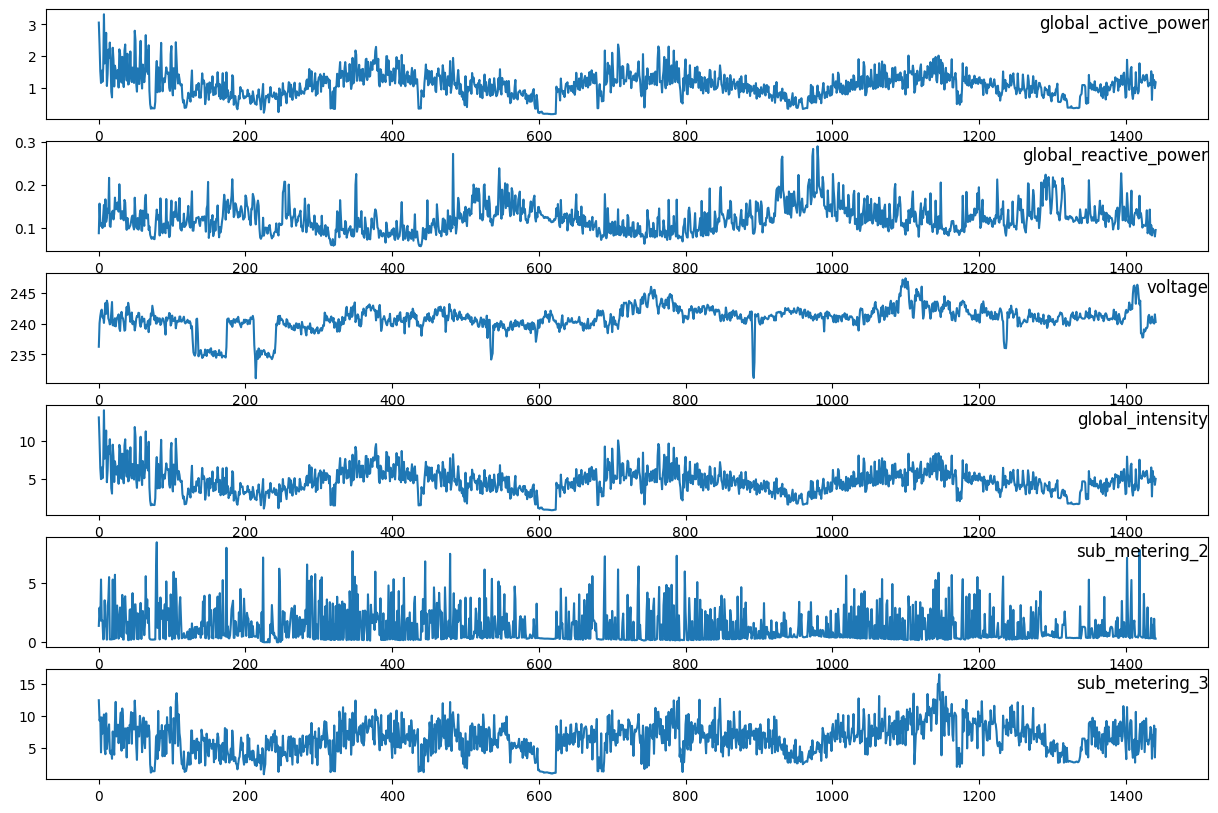

In [22]:
# Below I compare the mean of different featuresresampled over day.
# specify columns to plot
cols = [0, 1, 2, 3, 5, 6]
i = 1
groups=cols
values = df.resample('D').mean().values
# plot each column
plt.figure(figsize=(15, 10))
for group in groups:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.75, loc='right')
	i += 1

plt.savefig(filepath('compare the mean of different featuresresampled over day'))

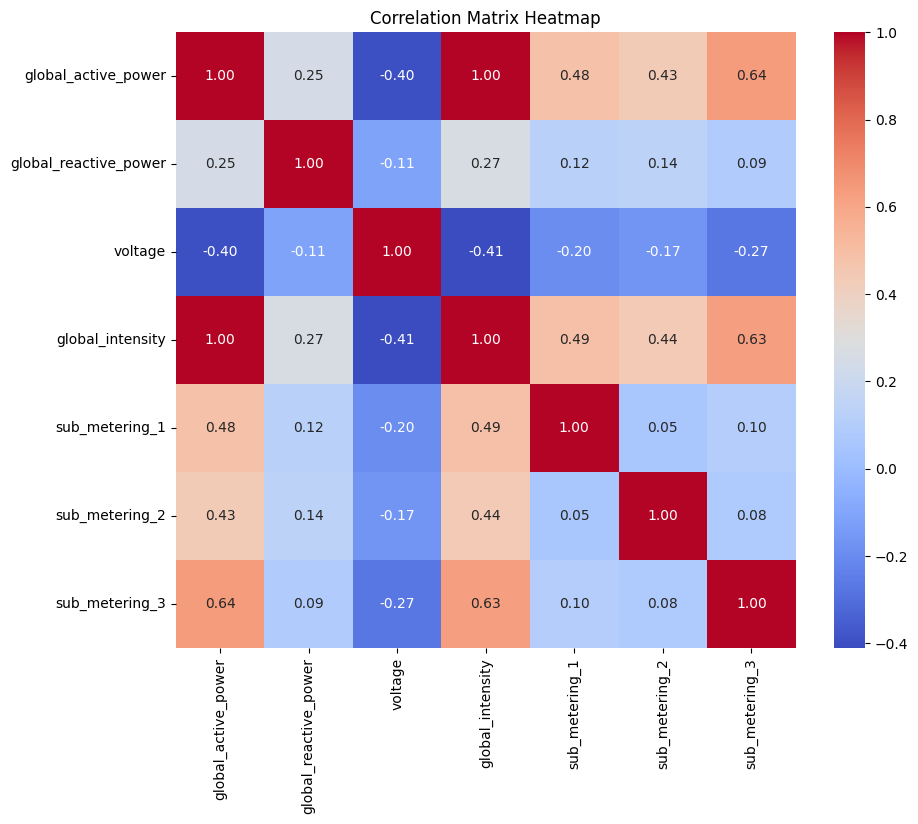

In [23]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.savefig(filepath('Correlation Matrix Heatmap'))

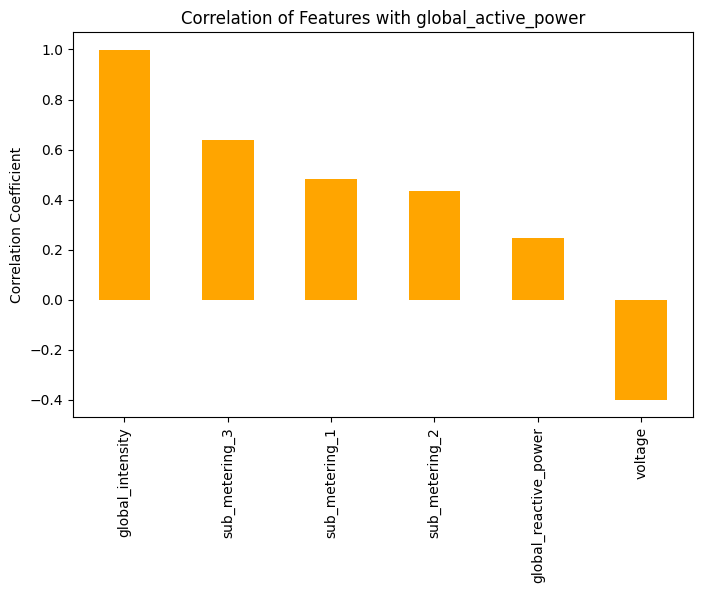

In [24]:
target = "global_active_power"
correlations = df.corr(numeric_only=True)[target].drop(target)

plt.figure(figsize=(8,5))
correlations.sort_values(ascending=False).plot(kind='bar', color="orange")
plt.title(f"Correlation of Features with {target}")
plt.ylabel("Correlation Coefficient")
plt.show()


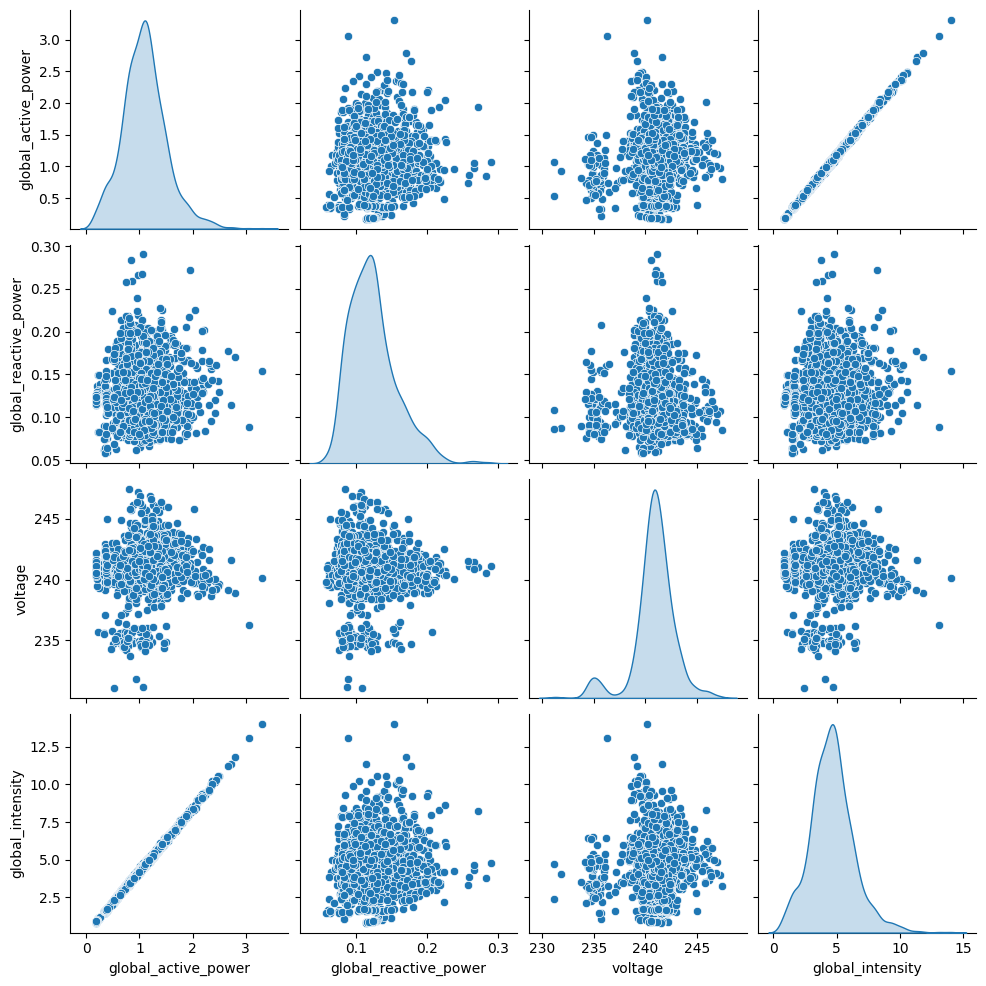

In [28]:
sns.pairplot(df[["global_active_power", "global_reactive_power", 
                 "voltage", "global_intensity"]].resample('D').mean(), diag_kind="kde")
plt.savefig(filepath('pair plot'))


In [34]:
name = iter('ANDRO')
print(*name)

A N D R O


[(0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (1, 17),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (2, 17),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (3, 16),
 (3, 17),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (4, 15),
 (4, 16),
 (4, 17),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (5, 15),
 (5, 16),
 (5, 17),
 (6, 9),
 (6, 10),
 (6, 11),
 (6, 12),
 (6, 13),
 (6, 14),
 (6, 15),
 (6, 16),
 (6, 17),
 (7, 9),
 (7, 10),
 (7, 11),
 (7, 12),
 (7, 13),
 (7, 14),
 (7, 15),
 (7, 16),
 (7, 17),
 (8, 9),
 (8, 10),
 (8, 11),
 (8, 12),
 (8, 13),
 (8, 14),
 (8, 15),
 (8, 16),
 (8, 17)]